<h1><center> You Only Look Once</center></h1>

# About this notebook


This is a python notebook with guided instruction and code base for training a YoloV1 detection model from scratch. 
The original paper can be found on ArXiv: https://arxiv.org/abs/1506.02640. The material is largely based on Aladdin Persson Youtube video : https://youtube.com/watch?v=n9_XyCGr-MI. You may also watch [the following video]( https://www.youtube.com/watch?v=2hAiJe8ITsE) by Chad Wakamiya for a shorter and more conceptual insight into Yolo.

# Part 0: Initialization (resources, import, hyperparameters)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import numpy as np
import torch

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but this is too large for most GPUs
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"
STOP_TRAIN_MAP_THRESH=0.9
SEED = 123


def manual_seed(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)

# Part 1: YoloV1 architecture
## &#8594; Principle
The principle of Yolo is depicted in the following figure. In essence, the input image is virtually split into $S\times S$ cells (S=3 in the illustration). The model is responsible for predicting $B=2$ boxes for each cell.
By convention, each box should be centered within its associated cell, but can expand outside that cell. Note, that this convention is not enforced strictly by the model, but simply in the supervision (see [Part 2](#part_2)).
![YoloV1Principle](notebook_img/yolo_working.png "Principle")

## &#8594; Global architecture (S=7)
The architecture is decomposed into a CNN backbone, and a fully-connected  head. The following graph depicts the architecture for $S=7$. In this graph, $n_C$ represent the number of classes in the dataset (for PascalVOC $n_C=20$).

![YoloV1Archi](notebook_img/yolo_archi.png "global architecture")

*NB:* the output tensor is of size $S\times S \times (n_C+10)$ because for each cell (among the $S\times S$ cells), two box predictions are in competitition. Each box is encoded as a 5-tuple $(p,x,y,w,h)$, where $p$ is the confidence, and the rest is the spatial extension. This account for $10$ values in the cell representation. The other $n_C$ values correspond to a 1-hot vector encoding the class associated to the box. Note that, a single box out of 2 will be retained. Therefore, a single 1hot vector of size $n_C$ is attached to each cell (and not 2). 

## &#8594; Backbone (darknet)
![backbone](notebook_img/darknet.png "Backbone architecture")

## &#8594; Exercise 1: build the described architecture 
To complete this exercise, you shall 
* complete the `_create_backbone` and `_create_head`  methods of the `YoloV1` class;
* and test that your Model can handle $3\times 448 \times 448$ tensors.

In [3]:
from model import Yolov1
def test_model_architecture():
    x = torch.zeros(1,3,448,448).to(DEVICE)
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    pred = model(x)
    if(pred.shape[1]==7*7*30):
        print('Model test [ok]')
    else:
        print(f'Model test [nok] : shape is {pred.shape} instead of {7*7*30}')

test_model_architecture()

Model test [ok]


<a id='part_2'></a>
# Part 2: Understanding the bounding box convention


## &#8594; Exercise 2: loading the data
In this exercise, you must complete the class `VOCDataset` in 'dataset.py' in order to handle the data provided in the 'data' folder. Note, that images are stored in the 'image' subfolder and the supervision in the 'label' folder. These two subdirectories are passed in the constructor of `VOCDataset` as the `img_dir` and `label_dir` arguments.

To complete this exercise, you should complete the `__convert_boxes_to_matrix` method of the `VOCDataset` class. Please look at the docstring of the method for mor details on how ground-truth boxes should be encoded. To test your implementation, run the following cell and verify that the depicted boxes make sense.

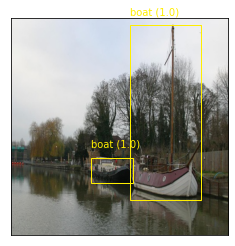

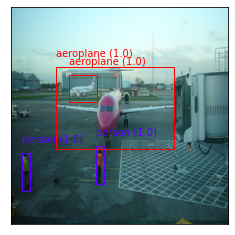

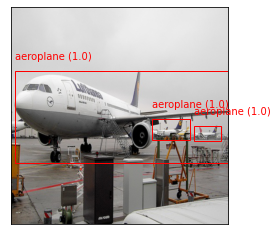

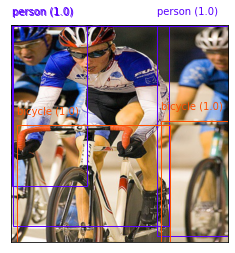

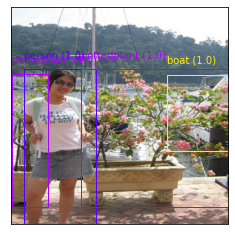

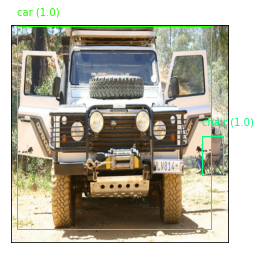

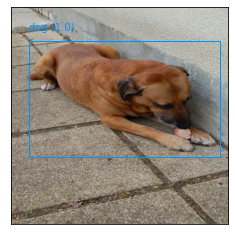

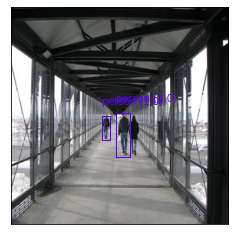

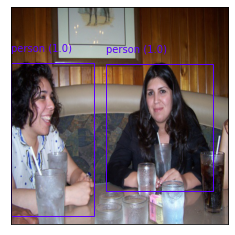

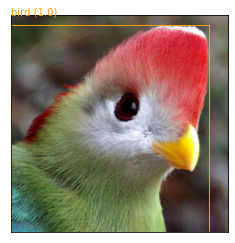

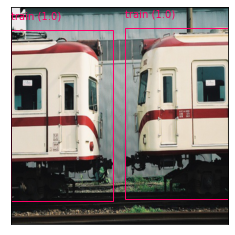

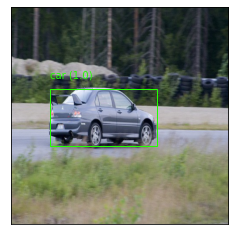

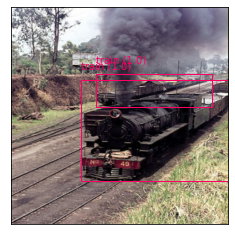

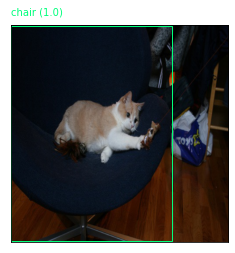

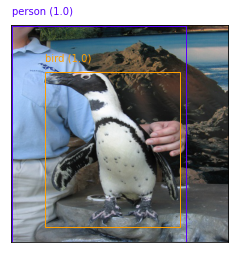

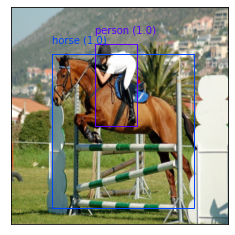

In [4]:
from torch.utils.data import DataLoader
from dataset import VOCDataset
import torchvision.transforms as transforms
from utils import cellboxes_to_boxes, plot_image

class TransformWithBoxes(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            if type(t) is tuple: #
                assert(len(t)==2)
                t_img, t_box = t
                img, bboxes = t_img(img), t_box(bboxes)
            else:
                img, bboxes = t(img), bboxes

        return img, bboxes


transform = TransformWithBoxes([transforms.Resize((448, 448)), transforms.ToTensor(),])

    
def make_loader(dataset_path, nb_samples):
    dataset = VOCDataset( 
        dataset_path, transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR, nb_samples=nb_samples
    )
    loader = DataLoader(
        dataset=dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, 
        shuffle=True, drop_last=True,
    )
    return loader

def test_loader():
    manual_seed(SEED)
    dataset='data/train.csv'
    nb_samples = BATCH_SIZE
    loader = make_loader(dataset, nb_samples)
    x,y = iter(loader).next()
    bboxes = cellboxes_to_boxes(y)

    for idx in range(nb_samples):
        cur_bboxes = bboxes[idx]
        cur_bboxes = [box for box in cur_bboxes if box[1]>.5]
        plot_image(x[idx].permute(1,2,0), cur_bboxes)


test_loader()

## &#8594; Exercise 3: Intersection over union and non max suppression
In this exercise, we aim at leveraging non max suppression filtering to reduce spurious detections created by the model. The principle of non max suppression is slightly fuzzy for boxes because there is no natural order withing boxes. Here is what we intend to do:
* order detected boxes by order of confidence and place them in a queue if their confidence is above a threshold
* repeat until the queue is empty
    * pop the most confident box `top_box` and remove any other box with the same class as `top_box` provided that their mutual IOU is larger than a threshold
    * place `top_box` in the output list of boxes
    
In order to implement this non max-suppression filtering will require that you implement first the IOU of two boxes. You should do so, by completing the `intersection_over_union` function in the 'utils.py' file. Once, this is done, you can test your implementation by running the following notebook cell.

*NB:* we recall that each box is encoded as a list of 5 elements $[p,x,y,w,h]$ of $[p,x1,y1,x2,y2]$ where $p$ is the confidence, and the remaining 4 parameters encode the box spatial extension. Two conventions can be used: 'midpoint' or 'corners'. In the first case, the first 2 parameters $x,y$ represent the center of the box, and the other two, the box size. In the 'corners conventions, the 4 parameters encode directly the two corners of the box.

In [5]:
from utils import intersection_over_union
def test_iou_midpoint():
    box1=torch.tensor([0.5, 0.6, 0.3, 0.2]).to(DEVICE)
    box2=torch.tensor([0.55, 0.55, 0.1, 0.3]).to(DEVICE)
    iou = intersection_over_union(box1, box2, box_format='midpoint')
    if abs(iou-0.2857)<1e-4:
        print('IOU midpoint test [ok]')
    else:
        print(f'IOU midpoint test [nok] : iou is {float(iou):.4f} instead of {0.2857}')

def test_iou_corners():
    box1=torch.tensor([0.2, 0.3, 0.4, 0.7]).to(DEVICE)
    box2=torch.tensor([0.3, 0.25, 0.8, 0.55]).to(DEVICE)
    iou = intersection_over_union(box1, box2, box_format='corners')
    if abs(iou-0.122)<1e-4:
        print('IOU corners test [ok]')
    else:
        print(f'IOU corners test [nok] : iou is {float(iou):.3f} instead of {0.122}')

test_iou_midpoint()
test_iou_corners()

IOU midpoint test [ok]
IOU corners test [ok]


Note that the IOU computation will be used later to compute a loss function. In that case, the IOU will be computed between a tensor of detected boxes and one of ground-truth boxes. In such case, the IOU should be computed element-wise. Adapt your implementation to handle this situation and test it again with the previous and the next cell.

In [6]:
def test_iou_midpoint():
    box1=torch.tensor([0.5, 0.6, 0.3, 0.2]).unsqueeze(0).repeat(2,1).to(DEVICE)
    box2=torch.tensor([0.55, 0.55, 0.1, 0.3]).unsqueeze(0).repeat(2,1).to(DEVICE)
    iou = intersection_over_union(box1, box2, box_format='midpoint')
    if (list(iou.shape) == [2,1]) and (torch.abs(iou-0.2857)<1e-4).all():
        print('IOU midpoint test [ok]')
    else:
        print(f'IOU midpoint test [nok] : iou is {iou} instead of [[0.2857], [0.2857]]')

def test_iou_corners():
    box1=torch.tensor([0.2, 0.3, 0.4, 0.7]).unsqueeze(0).repeat(2,1).to(DEVICE)
    box2=torch.tensor([0.3, 0.25, 0.8, 0.55]).unsqueeze(0).repeat(2,1).to(DEVICE)
    iou = intersection_over_union(box1, box2, box_format='corners')
    if (torch.abs(iou-0.122)<1e-4).all():
        print('IOU corners test [ok]')
    else:
        print(f'IOU corners test [nok] : iou is {iou} instead of [[0.112], [0.112]]')

test_iou_midpoint()
test_iou_corners()

IOU midpoint test [ok]
IOU corners test [ok]


Now that IOU works correctly, you shall implement the `non_max_suppression` function in 'utils.py' and test it by running the following cell.

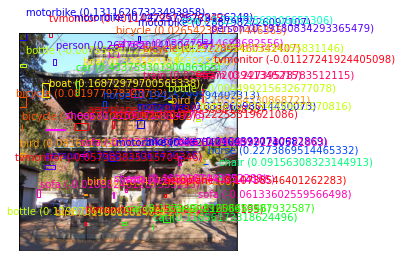

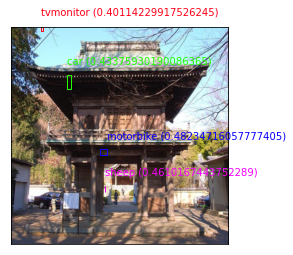

In [7]:
from utils import non_max_suppression

def test_boxes(dataset='data/train.csv', model=None,  nb_samples=128, nms=True, indices=None):
    torch.cuda.empty_cache()
    loader = make_loader(dataset, nb_samples)
    manual_seed(SEED)
    if model is None:
        model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
        if LOAD_MODEL:
            optimizer = optim.Adam(
              model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
            ) 
            load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    x,y = iter(loader).next()
    x = x.to(DEVICE)
    bboxes = cellboxes_to_boxes(model(x))
    if indices is None:
        indices = range(8)
    for idx in indices:
        cur_bboxes = bboxes[idx]
        if nms:
            cur_bboxes = non_max_suppression(cur_bboxes, iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), cur_bboxes)

LOAD_MODEL = False

test_boxes('data/train.csv', nb_samples=128,nms=False, indices = [7])
test_boxes('data/train.csv', nb_samples=128,nms=True, indices=[7])

# Part 3: Preparing the training (loss and mAP)

##  &#8594; Exercise 4: Loss function
In this exercise you will complete the `forward` method of the `YoloLoss` class in `loss.py`. This method, takes a tensor of predicted boxes called `predictions` and one of ground-truth boxes called `target`. Because the predictions include 2 boxes per cells (and target only one),  the `predictions` tensor is shaped as $N\times S \times S \times (n_C+10)$ (while `target` is shaped as $N\times S \times S \times (n_C+5)$). Note that in the loss context, the boxes are assumed to be expressed in the 'midpoint' convention.

Considering a particular sample in the batch, and a particular cell, the loss will combine several terms. Denoting,
$y$ the class logits attached to the predection, $p^1, p^2$ the confidence for each of the competing 2 box predictions, and $box^1,box^2$ their extensions, one can be describe the loss mathematically as follows.

$$L(y,p^1,box^1,p^2,box^2| y_{gt},p_{gt},box_{gt}) = p_{gt}\left[L_{class}(y,y_{gt}) + \lambda_{reg} p_{gt}\times +  L_{obj}(p^*|p_{gt}) + L_{reg}(box^*|box_{gt}) \right] +\lambda_{bck}(1-p_{gt})*L_{bck}(p^1,p^2|p_{gt}, p_{gt})$$

where, $p^*,box*$ correspond to the box with largest IOU w.r.t to the ground-truth box, and $L_{class}, L_{obj}$ and $L_{back}$ are all the MSE loss. And $L_{reg}$ is also the MSE with a minor modification, if $box^*=(x,y,w,h)$ and $box_{gt}=(x_{gt},y_{gt},w_{gt},h_{gt})$ then 

$$L_{reg}(box^*|box_{gt})= MSE\left((x,y,\sqrt{|w|+\epsilon},\sqrt{|h|+\epsilon})\mid|(x_{gt},y_{gt},\sqrt{|w_{gt}|+\epsilon},\sqrt{|h_{gt}|+\epsilon})\right)$$

where $\epsilon=1e-6$ prevents non-differentiability issues.

Implement the previous loss function and test it by running the following cell. 

In [8]:
from loss import YoloLoss
def test_loss():
    loss_fn = YoloLoss(S=2)
    target = torch.tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.4930, 0.6682, 6.9580, 6.6637], [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],
        [[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.6900, 0.5000, 4.5920, 6.9613]], [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]])
    predictions = torch.tensor([[[[ 0.0722,  0.2930,  0.1355, -0.4048, -0.1384,  0.0728,  0.0111, 0.0823,  0.0610,  0.4526,  0.0390, -0.3689, -0.0619, -0.1929, 0.1514, -0.0166, -0.1900,  0.1680, -0.0636, -0.0566,  0.2471, 0.0842, -0.1117,  0.0759, -0.2404, -0.0430,  0.0019, -0.1824, -0.3008,  0.4701], [-0.2021,  0.5200,  0.4965,  0.0686,  0.0117,  0.2321, -0.0744, -0.3393, -0.4089, -0.1446, -0.0391, -0.1870, -0.2536, -0.1668, -0.3071, -0.0369, -0.2382, -0.1575,  0.1798, -0.0028,  0.2517, -0.0268, -0.1238,  0.0829, -0.1045, -0.1113,  0.1411, -0.1178, -0.0432,  0.1688]], [[-0.0103, -0.2407, -0.1889,  0.0118, -0.0587,  0.0954, -0.0972, -0.0400,  0.1040,  0.1032,  0.3512, -0.2157,  0.1354, -0.0177, 0.2601,  0.1982, -0.2826, -0.1293, -0.2516,  0.0848,  0.0011, -0.0771, -0.1776,  0.2047,  0.0851,  0.0274,  0.0483, -0.0890, -0.0714, -0.0915], [ 0.0868, -0.0316, -0.2700, -0.3170,  0.1119,  0.1375, -0.2995, 0.0785, -0.1637, -0.3458,  0.0848, -0.2524,  0.0540,  0.2113, -0.0323,  0.0544,  0.1325, -0.0754, -0.1505, -0.1518, -0.1447, -0.2084,  0.3286,  0.2597,  0.0422,  0.0704,  0.2716,  0.1622, -0.1276, -0.1169]]],
        [[[-0.0327,  0.2024, -0.0813, -0.1000, -0.0020,  0.0671,  0.0386, 0.0582, -0.1740,  0.1345,  0.1179, -0.1703, -0.1787, -0.1370, -0.1351,  0.0178, -0.0679, -0.0616,  0.1185,  0.0508, -0.0878, 0.2748, -0.0030,  0.0163, -0.0867, -0.2532, -0.1322, -0.0291, -0.1244, -0.1477], [-0.1313,  0.1930,  0.1955,  0.0404,  0.1078,  0.1077,  0.0031, -0.1576, -0.2182, -0.0276, -0.1187,  0.0232, -0.0717, -0.0498, 0.0351, -0.1843, -0.1401,  0.0862, -0.0830,  0.2090,  0.0510, 0.1188, -0.0505, -0.0981, -0.0161,  0.1826,  0.0484, -0.0699, 0.1382, -0.1988]], [[ 0.0578, -0.1894,  0.1362, -0.0791,  0.0314,  0.2630,  0.1435, -0.0619, -0.0712, -0.1239,  0.2230, -0.0951, -0.1013,  0.1092, -0.0030, -0.0291, -0.3092, -0.1111, -0.0402,  0.2405,  0.0552, -0.2141, -0.0881,  0.1696,  0.0909,  0.0652,  0.0326, -0.0544, -0.0817, -0.2321], [-0.0173, -0.1482, -0.3465, -0.1246, -0.1611, -0.1660, -0.2254, -0.0140, -0.0107, -0.2530, -0.0813, -0.1340,  0.0676,  0.0584, 0.0992,  0.0111, -0.0973, -0.2905, -0.0184, -0.2086,  0.0360, -0.2379, -0.1167,  0.2013,  0.0571, -0.0035,  0.1667,  0.1881, -0.2229,  0.0050]]]])

    with torch.no_grad():
        loss = loss_fn(predictions, target)
        if abs(loss-155.0789)<1e-4:
            print('Loss test [ok]')
        else:
            print(f'Loss test [nok] : loss is {float(loss):.4f} instead of {155.0789}')

    
test_loss()

Loss test [ok]


##  &#8594; Exercise 5: Mean Average Precision (mAP)
The loss function is merely a differentiable proxy for another evaluation metric that we would like to optimize, namely the mean average precision. This metric works as follows: 
* For each class we shall compute the so-called average precision (detailed later)
* Then we will return the mean of those average precisions (hence the mAP)

### Average precision in classification
For a binary classifier of the form $f(x)<\tau$, the notion of average precision is simple. One computes the precision-recall curve of the classifier, which is a curve parameterized by the threshold  $\tau$ used to make the decision. The curve represents the values of the 'precision' $\alpha$ in y-axis against the 'recall' $\beta$ in x-axis. For a value $\tau$ of the threshold, one computes first the number of true positive examples $TP(\tau)$ (i.e the classifier predicts a positive example and the example is indeed positive according to the ground-truth), and the false positive $FP($\tau)$ (i.e. samples predicted as positive but actually negative). Once these values are known,

$$\begin{aligned}
\alpha(\tau):=&TP(\tau)/ (TP(\tau) + FP(\tau))\\
\beta(\tau):=&TP(\tau)/ \#\{x_k / y_k=1\}\\
\end{aligned}
$$

In practice, one considers only the discrete set of values $\tau_k=f(x_k)$ where $x_k$ are the evaluation samples. 
Once the entire curve is known, the *average precision* defined theoretically as $\int \alpha d\beta$ and can be estimated from the discrete curve by numerical methods (e.g trapezoid method : see [torch.trapz](https://pytorch.org/docs/stable/generated/torch.trapz.html))

For a multiclass classification problem, the average precision can be computed per-class and then averaged over the classes, yielding the notion of mean average precision (mAP).

### Average precision for detection
Now, for detection, the situations is slightly more complicated because one would like to account for the accuracy of the detected bounding box as well as the notion of classification precision. One needs to decide wether a predicted box and a ground-truth box match. To do so, we set-up a *fixed* IOU threshold (0.5 in our case), and consider that the two boxes are the same if their IOU is larger than this threshold and they have the same class. Besides, we want the prediction vs ground-truth mapping to be one-to-one, so we shall do the following:
* predictions will be sorted by order of confidence
* as we are building the association, we are going to store if ground-truth is already associated to a prediction (which is why we consider them by order of confidence)
* every prediction will be associated to the ground-truth with largest IOU, unless this ground-truth is already associated with another prediction or unless the obtained IOU is smaller than the fixed threshold
* every prediction successfully associated to a ground truth is accounted as a true positive example, and the rest is tacitly considered as false positive.

At the end of this procedure, we conceptually get a vector of boolean denote `TP` which stores for each prediction whether it is a true positive or a false positive. Actually the vector `FP` is the logical negation of this vector.

Once this is done, we can compute the precision and recall curve by considering a threshold over the confidence of the predictions (this one is not fixed and should take all the confidence values within the predictions). Since the detections were sorted by confidence, one may simply consider the cumulative sums of both `TP` and `FP` (both casted as integer vectors):
$$\begin{aligned}
list_\alpha:=&\mathrm{cumsum}(TP)/ (\mathrm{cumsum}(TP)+\mathrm{cumsum}(FP))\\
list_\beta:=&\mathrm{cumsum}(TP)/ \#\{\text{ground truth boxes with considered class} \}\\
\end{aligned}
$$
One then must compute the average precision using numerical integration.

### Back to the exercice:
To complete this exercise, you should finish the implementation of the `mean_average_precision` function in 'utils.py'. Please, read carefully the docstring of the function to know how boxes are encoded. 

*NB:* One difficulty in the exercise consist in handling the fact in handling the fact that ground-truth and detection boxes come from a particular example. One should take care that a detection can be associated with a ground truth of the same example (IOU between 2 boxes from different images is indeed meaningless). Yet, one cannot deal with detections one sample at a time, because detections should be ordered by confidence (and not by train sample). To make your work simpler, a helper class called `GroundTruthOccupancy` is provided, which allow to check if a ground-truth is available, and in that case make it unavailable.

You can then test your work by running the following notebook cell.

In [9]:
from utils import mean_average_precision
def test_mAP():
    predictions=[[0, 17.0, 1.0280905961990356, 0.46768784523010254, 0.6217789649963379, 0.8745735883712769, 0.6425503492355347], [0, 11.0, 1.0061979293823242, 0.4828431010246277, 0.5360883474349976, 0.5415377020835876, 0.3670983910560608], [1, 6.0, 0.896679162979126, 0.5926629304885864, 0.4452129602432251, 0.2131536602973938, 0.07241526991128922], [2, 18.0, 0.9845926761627197, 0.7815631031990051, 0.49166974425315857, 0.4470129609107971, 0.763695478439331], [2, 18.0, 0.9315635561943054, 0.23425798118114471, 0.512854814529419, 0.46540355682373047, 0.7796798348426819], [3, 8.0, 0.997340202331543, 0.34627288579940796, 0.4438081681728363, 0.5559816360473633, 0.6236485242843628], [3, 14.0, 0.9781200885772705, 0.18720586597919464, 0.4576720595359802, 0.3049735724925995, 0.8125137090682983], [3, 14.0, 0.9552692770957947, 0.7691924571990967, 0.6756914854049683, 0.24334794282913208, 0.5790932178497314], [3, 14.0, 0.8838805556297302, 0.5179936289787292, 0.8057070374488831, 0.5777050852775574, 0.40052664279937744], [4, 7.0, 0.9657518267631531, 0.47993209958076477, 0.5084319710731506, 0.8012773990631104, 0.8267120718955994], [5, 14.0, 1.039970874786377, 0.7551921606063843, 0.6139463782310486, 0.294821172952652, 0.7150313854217529], [5, 14.0, 0.880236804485321, 0.2656441032886505, 0.4978722333908081, 0.5126967430114746, 0.8834100365638733], [5, 19.0, 0.8435073494911194, 0.8842479586601257, 0.5411088466644287, 0.2247460037469864, 0.4824884235858917], [6, 11.0, 1.1188104152679443, 0.4894183278083801, 0.3153427243232727, 0.6375594139099121, 0.4589642882347107], [6, 11.0, 0.9621081352233887, 0.48356086015701294, 0.5711842775344849, 0.818712592124939, 0.7751135230064392], [7, 14.0, 1.0275242328643799, 0.46580639481544495, 0.369585245847702, 0.18630866706371307, 0.3764039874076843], [7, 12.0, 0.9510059356689453, 0.5222050547599792, 0.5672581195831299, 0.6000235080718994, 0.6812225580215454], [8, 14.0, 0.9054757356643677, 0.4919682443141937, 0.592993974685669, 0.04010191559791565, 0.18633826076984406], [8, 14.0, 0.8737761378288269, 0.45781049132347107, 0.5755922794342041, 0.03431752324104309, 0.09319524466991425], [9, 11.0, 1.033682942390442, 0.49763333797454834, 0.42401158809661865, 0.7320272922515869, 0.5121123194694519], [10, 7.0, 1.0510544776916504, 0.34250906109809875, 0.4835251271724701, 0.5998551249504089, 0.9307482838630676], [10, 7.0, 0.9464461803436279, 0.7487518787384033, 0.5067002177238464, 0.4966554045677185, 0.9118269085884094], [11, 14.0, 1.0800682306289673, 0.19188442826271057, 0.6203898191452026, 0.3743067979812622, 0.6487419009208679], [11, 14.0, 0.9755352735519409, 0.700608491897583, 0.5397668480873108, 0.47698894143104553, 0.5735412836074829], [12, 6.0, 0.9925071597099304, 0.4852342903614044, 0.6268920302391052, 0.8927691578865051, 0.5972539782524109], [13, 18.0, 1.149222493171692, 0.6799855828285217, 0.40829506516456604, 0.5120123028755188, 0.1530190259218216], [13, 18.0, 1.045691967010498, 0.6762720942497253, 0.5484884977340698, 0.6313760280609131, 0.4606327414512634], [14, 14.0, 1.0527225732803345, 0.2485308200120926, 0.6194025278091431, 0.3004094064235687, 0.6915444731712341], [14, 15.0, 1.0197774171829224, 0.6513016223907471, 0.6084359884262085, 0.6046556830406189, 0.6237947344779968], [14, 15.0, 1.0013201236724854, 0.0829709991812706, 0.5988578796386719, 0.14565955102443695, 0.6096314191818237], [14, 3.0, 0.9339202046394348, 0.8526462912559509, 0.5218344926834106, 0.2712861895561218, 0.3496682941913605], [15, 14.0, 1.1128939390182495, 0.4177345931529999, 0.48788610100746155, 0.7114344239234924, 0.8857803344726562], [15, 2.0, 0.9106618165969849, 0.464143306016922, 0.5713090300559998, 0.6021574139595032, 0.6784215569496155], [16, 8.0, 1.0874377489089966, 0.10206574946641922, 0.3742050230503082, 0.06818373501300812, 0.12237805128097534], [16, 8.0, 1.0149075984954834, 0.8960371613502502, 0.3977256715297699, 0.07391813397407532, 0.10914725065231323], [16, 8.0, 1.0025509595870972, 0.2988756597042084, 0.4233258068561554, 0.05033282935619354, 0.06371196359395981], [16, 8.0, 0.9847186803817749, 0.17644865810871124, 0.4010845720767975, 0.06238330528140068, 0.11152239143848419], [16, 8.0, 0.9223700761795044, 0.7669896483421326, 0.4182007908821106, 0.04686560481786728, 0.10416053235530853], [17, 14.0, 1.0117621421813965, 0.17149223387241364, 0.30045586824417114, 0.13586853444576263, 0.32133781909942627], [17, 6.0, 0.9739434123039246, 0.5673094391822815, 0.5040762424468994, 0.7060273885726929, 0.8131642937660217], [17, 14.0, 0.9683375358581543, 0.3402155637741089, 0.16515156626701355, 0.10793904960155487, 0.290774941444397], [17, 14.0, 0.9458729028701782, 0.7969663739204407, 0.21735741198062897, 0.14554595947265625, 0.35488834977149963], [17, 14.0, 0.802965521812439, 0.056880801916122437, 0.33444827795028687, 0.15415112674236298, 0.5228168368339539], [18, 14.0, 1.0061177015304565, 0.550126850605011, 0.5167673826217651, 0.7413385510444641, 0.9529196619987488], [18, 12.0, 0.8945019841194153, 0.5258451700210571, 0.7260497212409973, 0.4517662823200226, 0.5548471808433533], [19, 14.0, 1.0908043384552002, 0.46620798110961914, 0.47721171379089355, 0.27971574664115906, 0.6325066089630127], [19, 14.0, 1.0363954305648804, 0.8809204697608948, 0.6270651817321777, 0.25825658440589905, 0.6699010729789734], [19, 14.0, 1.0163118839263916, 0.6768831014633179, 0.5914976596832275, 0.4095347821712494, 0.8066529631614685], [19, 14.0, 0.9099281430244446, 0.17459625005722046, 0.5120633244514465, 0.28932127356529236, 0.7145296931266785], [20, 14.0, 1.0858047008514404, 0.06871955841779709, 0.7521108984947205, 0.03276800736784935, 0.1769140213727951], [20, 0.0, 0.9025355577468872, 0.3267752230167389, 0.3761923909187317, 0.12603428959846497, 0.139728844165802], [20, 14.0, 0.8997650146484375, 0.409089595079422, 0.7428795099258423, 0.04592422395944595, 0.1946994513273239], [20, 0.0, 0.885096549987793, 0.5062527060508728, 0.4546806812286377, 0.5739096999168396, 0.39363160729408264], [21, 8.0, 0.9752703309059143, 0.4090641438961029, 0.47338879108428955, 0.7445420026779175, 0.9740234017372131], [22, 0.0, 1.130724549293518, 0.5206438302993774, 0.5057865977287292, 0.8881187438964844, 0.4649360477924347], [22, 0.0, 0.9672148823738098, 0.9041290879249573, 0.5673260688781738, 0.12942850589752197, 0.07670260965824127], [22, 0.0, 0.8615709543228149, 0.7231013178825378, 0.5638639330863953, 0.17833992838859558, 0.08952966332435608], [23, 11.0, 0.9488651156425476, 0.5283204913139343, 0.5039528012275696, 0.6296132802963257, 0.3740074336528778], [23, 8.0, 0.899711012840271, 0.9184807538986206, 0.37518545985221863, 0.09620435535907745, 0.08385176956653595], [24, 14.0, 1.0412296056747437, 0.5083138942718506, 0.4683842062950134, 0.6228276491165161, 0.9118673205375671], [24, 1.0, 0.9153664708137512, 0.5097238421440125, 0.7317277193069458, 0.5432091355323792, 0.6074538230895996], [24, 14.0, 0.8976446986198425, 0.829088032245636, 0.47762253880500793, 0.2542140483856201, 0.8498020768165588], [25, 6.0, 1.0146623849868774, 0.4330834150314331, 0.5015992522239685, 0.47392240166664124, 0.2881729006767273], [26, 3.0, 1.0374513864517212, 0.7197017073631287, 0.40688925981521606, 0.3698634207248688, 0.7832537293434143], [26, 3.0, 0.9843042492866516, 0.45855748653411865, 0.6876971125602722, 0.1820986568927765, 0.12235067039728165], [27, 6.0, 1.0011584758758545, 0.32706019282341003, 0.6937821507453918, 0.13622340559959412, 0.1243705302476883], [27, 6.0, 0.8860047459602356, 0.19666975736618042, 0.7073504328727722, 0.06389448046684265, 0.06883479654788971], [28, 1.0, 1.0960443019866943, 0.40143027901649475, 0.7441744208335876, 0.6504635214805603, 0.5096194744110107], [28, 1.0, 1.0007444620132446, 0.8710357546806335, 0.7082658410072327, 0.3021041750907898, 0.5508813261985779], [28, 14.0, 0.9572879076004028, 0.3490859568119049, 0.4505133032798767, 0.6546957492828369, 0.7989155054092407], [28, 14.0, 0.9067924618721008, 0.8432819843292236, 0.5086069107055664, 0.3427065908908844, 0.9327065944671631], [28, 14.0, 0.9022829532623291, 0.18174050748348236, 0.3961729407310486, 0.3524542450904846, 0.6997862458229065], [29, 6.0, 1.1417282819747925, 0.48843759298324585, 0.468502938747406, 0.8868585228919983, 0.937678873538971], [29, 8.0, 0.9765521883964539, 0.9201012253761292, 0.6238563060760498, 0.10225408524274826, 0.18911926448345184], [30, 2.0, 1.0536518096923828, 0.45847439765930176, 0.5293163657188416, 0.8113543391227722, 0.8571189045906067], [31, 2.0, 0.95622718334198, 0.4574514627456665, 0.5224674940109253, 0.9957689046859741, 0.9908163547515869]]
    targets=[[0, 11.0, 1.0, 0.4930000305175781, 0.5561097860336304, 0.5580000281333923, 0.3840399384498596], [0, 17.0, 1.0, 0.5020000338554382, 0.6408977508544922, 0.9960000514984131, 0.7182045578956604], [1, 6.0, 1.0, 0.5950000286102295, 0.4506666958332062, 0.242000013589859, 0.11733333021402359], [2, 18.0, 1.0, 0.23600000143051147, 0.5, 0.46800002455711365, 0.7850746512413025], [2, 18.0, 1.0, 0.7630000710487366, 0.4880596995353699, 0.4740000367164612, 0.7850746512413025], [3, 14.0, 1.0, 0.203000009059906, 0.4839572310447693, 0.32600003480911255, 0.9304812550544739], [3, 8.0, 1.0, 0.33900001645088196, 0.45721927285194397, 0.5899999737739563, 0.6417112350463867], [3, 14.0, 1.0, 0.7870000004768372, 0.6764705777168274, 0.2460000067949295, 0.6042780876159668], [3, 14.0, 1.0, 0.5270000696182251, 0.7874332070350647, 0.6620000004768372, 0.42513367533683777], [4, 7.0, 1.0, 0.49052634835243225, 0.5145833492279053, 0.8294737339019775, 0.9458333849906921], [5, 14.0, 1.0, 0.2850000262260437, 0.5105105638504028, 0.5619999766349792, 0.9789789915084839], [5, 19.0, 1.0, 0.9030000567436218, 0.5630630850791931, 0.1940000206232071, 0.4654654562473297], [5, 14.0, 1.0, 0.7330000400543213, 0.6126126050949097, 0.3019999861717224, 0.7747748494148254], [6, 11.0, 1.0, 0.531000018119812, 0.3329355716705322, 0.6860000491142273, 0.4701670706272125], [6, 11.0, 1.0, 0.49000003933906555, 0.5811455845832825, 0.9200000762939453, 0.8042959570884705], [7, 14.0, 1.0, 0.4833333492279053, 0.35851651430130005, 0.19583335518836975, 0.37637364864349365], [7, 12.0, 1.0, 0.5135416388511658, 0.5686813592910767, 0.6520833373069763, 0.708791196346283], [8, 14.0, 1.0, 0.437000036239624, 0.5559999942779541, 0.03800000250339508, 0.11466667056083679], [8, 14.0, 1.0, 0.515999972820282, 0.5880000591278076, 0.06400000303983688, 0.20533333718776703], [9, 11.0, 1.0, 0.5210843086242676, 0.4230000078678131, 0.8795181512832642, 0.5299999713897705], [10, 7.0, 1.0, 0.30799999833106995, 0.5015015006065369, 0.6080000400543213, 0.996997058391571], [10, 7.0, 1.0, 0.7400000691413879, 0.5015015006065369, 0.5199999809265137, 0.996997058391571], [11, 14.0, 1.0, 0.6830000281333923, 0.5546666979789734, 0.49400001764297485, 0.5866667032241821], [11, 14.0, 1.0, 0.19200000166893005, 0.609333336353302, 0.3799999952316284, 0.7066667079925537], [12, 6.0, 1.0, 0.4880000352859497, 0.5997304320335388, 0.972000002861023, 0.5795148015022278], [13, 18.0, 1.0, 0.658333420753479, 0.38200002908706665, 0.533333420753479, 0.15200001001358032], [13, 18.0, 1.0, 0.6611111760139465, 0.5670000314712524, 0.6777778267860413, 0.4659999907016754], [14, 3.0, 1.0, 0.8600000143051147, 0.4860000014305115, 0.2800000309944153, 0.35200002789497375], [14, 15.0, 1.0, 0.08800000697374344, 0.6130000352859497, 0.1653333455324173, 0.6100000143051147], [14, 14.0, 1.0, 0.2240000218153, 0.6430000066757202, 0.3306666910648346, 0.7140000462532043], [14, 15.0, 1.0, 0.6613333821296692, 0.6029999852180481, 0.677333414554596, 0.6340000629425049], [15, 14.0, 1.0, 0.40533336997032166, 0.5010000467300415, 0.800000011920929, 0.9980000257492065], [15, 2.0, 1.0, 0.46533334255218506, 0.5720000267028809, 0.6213334202766418, 0.7160000205039978], [16, 8.0, 1.0, 0.09800000488758087, 0.37687692046165466, 0.06400000303983688, 0.12312313169240952], [16, 8.0, 1.0, 0.19100001454353333, 0.39489492774009705, 0.07400000095367432, 0.10510510951280594], [16, 8.0, 1.0, 0.32100000977516174, 0.41291293501853943, 0.058000002056360245, 0.07507507503032684], [16, 8.0, 1.0, 0.7749999761581421, 0.41141143441200256, 0.058000002056360245, 0.09609610587358475], [16, 8.0, 1.0, 0.8999999761581421, 0.3918918967247009, 0.06000000238418579, 0.111111119389534], [17, 14.0, 1.0, 0.3310000002384186, 0.19369371235370636, 0.10999999940395355, 0.3033033311367035], [17, 14.0, 1.0, 0.8149999976158142, 0.20570571720600128, 0.10999999940395355, 0.39939942955970764], [17, 14.0, 1.0, 0.07600000500679016, 0.3363363444805145, 0.14800000190734863, 0.5525525808334351], [17, 14.0, 1.0, 0.17399999499320984, 0.30630630254745483, 0.1080000102519989, 0.3243243098258972], [17, 6.0, 1.0, 0.5559999942779541, 0.5135135054588318, 0.6759999990463257, 0.8288288712501526], [18, 14.0, 1.0, 0.535794198513031, 0.5180000066757202, 0.744966447353363, 0.9640000462532043], [18, 12.0, 1.0, 0.5290827751159668, 0.7269999980926514, 0.45413869619369507, 0.5460000038146973], [19, 14.0, 1.0, 0.1600000113248825, 0.5135542750358582, 0.29600000381469727, 0.6897590160369873], [19, 14.0, 1.0, 0.4280000329017639, 0.47590363025665283, 0.2759999930858612, 0.6024096608161926], [19, 14.0, 1.0, 0.6639999747276306, 0.5813252925872803, 0.4320000410079956, 0.8373494744300842], [19, 14.0, 1.0, 0.8630000352859497, 0.6445783376693726, 0.27400001883506775, 0.7108433842658997], [20, 0.0, 1.0, 0.33000004291534424, 0.37544482946395874, 0.12800000607967377, 0.12455517053604126], [20, 0.0, 1.0, 0.4790000021457672, 0.4644128382205963, 0.5419999957084656, 0.3736654818058014], [20, 14.0, 1.0, 0.07000000774860382, 0.7597864866256714, 0.035999998450279236, 0.1743772327899933], [20, 14.0, 1.0, 0.40800002217292786, 0.7277580499649048, 0.035999998450279236, 0.1743772327899933], [21, 8.0, 1.0, 0.3709999918937683, 0.49699702858924866, 0.7380000352859497, 0.9879880547523499], [22, 0.0, 1.0, 0.5080000758171082, 0.505464494228363, 0.9800000786781311, 0.4262295365333557], [22, 0.0, 1.0, 0.7360000014305115, 0.5614754557609558, 0.1720000058412552, 0.09562841802835464], [22, 0.0, 1.0, 0.9030000567436218, 0.5819672346115112, 0.12200000882148743, 0.07103826105594635], [23, 8.0, 1.0, 0.9054054021835327, 0.36000001430511475, 0.08708708733320236, 0.07199999690055847], [23, 11.0, 1.0, 0.5210210680961609, 0.5020000338554382, 0.6216216087341309, 0.30799999833106995], [24, 14.0, 1.0, 0.5179640650749207, 0.46299999952316284, 0.5928143858909607, 0.9220000505447388], [24, 14.0, 1.0, 0.8772455453872681, 0.5059999823570251, 0.24550898373126984, 0.9360000491142273], [24, 1.0, 1.0, 0.4865269660949707, 0.7020000219345093, 0.5538922548294067, 0.5960000157356262], [25, 6.0, 1.0, 0.4269999861717224, 0.5060060024261475, 0.49400001764297485, 0.2612612843513489], [26, 3.0, 1.0, 0.7110000848770142, 0.4354354441165924, 0.32600003480911255, 0.8048048615455627], [26, 3.0, 1.0, 0.4650000333786011, 0.6996996998786926, 0.1940000206232071, 0.11411412060260773], [27, 6.0, 1.0, 0.1860000193119049, 0.6880000233650208, 0.04800000041723251, 0.0533333346247673], [27, 6.0, 1.0, 0.320000022649765, 0.7000000476837158, 0.14000001549720764, 0.11466667056083679], [28, 14.0, 1.0, 0.178143709897995, 0.37000003457069397, 0.344311386346817, 0.7360000014305115], [28, 14.0, 1.0, 0.36826351284980774, 0.46400001645088196, 0.71856290102005, 0.9200000762939453], [28, 14.0, 1.0, 0.8368263840675354, 0.4870000183582306, 0.326347291469574, 0.9700000286102295], [28, 1.0, 1.0, 0.3802395462989807, 0.7300000786781311, 0.7065868973731995, 0.5400000810623169], [28, 1.0, 1.0, 0.8443114161491394, 0.7200000286102295, 0.31137725710868835, 0.5600000619888306], [29, 6.0, 1.0, 0.4740000367164612, 0.4699699878692627, 0.8880000710487366, 0.9339339733123779], [29, 8.0, 1.0, 0.9259999990463257, 0.6006006002426147, 0.09600000083446503, 0.18018017709255219], [30, 2.0, 1.0, 0.4429999887943268, 0.5342790484428406, 0.7860000133514404, 0.817966878414154], [31, 2.0, 1.0, 0.45564520359039307, 0.5230000019073486, 0.907258152961731, 0.9540000557899475]]
    mAP = mean_average_precision(
        predictions, targets, iou_threshold=0.5, box_format="midpoint"
    )
    if (abs(mAP-0.9672)<1e-4):
        print('Test mAP [ok]')
    else:
        print(f'Test mAP [nok]: mAP={mAP} instead of 0.9672')


test_mAP()

Test mAP [ok]


# Part 4: Actual training
##  &#8594; Exercise 6: Training loop (don't be hasty!)
In this part, you should implement the main training loop, and keep track of
* the training loss
* the mean average precision (mAP) over the training set
* the mean average precision (mAP) over the test set

Start by testing if you can overfit a small number of examples (`128`)
Here is an example of plot you should obtain (with `nb_train_samples=1264` instead of `128`):
![training curves](notebook_img/yolo.png "Training curves")
```
Loss
	loss             	 (min:   14.125, max:  510.337, cur:   14.376)
mAP
	training         	 (min:    0.000, max:    0.899, cur:    0.892)
	validation       	 (min:    0.000, max:    0.128, cur:    0.128)

'Terminating training after 105 epochs because mAP=0.9138056039810181 > 0.9'
```

In [ ]:
import torch
import torch.optim as optim
import tqdm
from tqdm.notebook import tqdm
from model import Yolov1
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
    save_model_trace,
    load_model_trace
)
from loss import YoloLoss


def train(nb_train_samples=128, nb_test_samples=32):
    '''Exercise 6: Complete the training Loop'''
    torch.cuda.empty_cache()
    manual_seed(SEED)
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_loader = make_loader('data/train.csv', nb_samples=nb_train_samples)
    test_loader = make_loader('data/test.csv', nb_samples=nb_test_samples)


    main_loop = tqdm(range(EPOCHS))
    for epoch in main_loop:
        avg_Loss = epoch
        mAP = EPOCHS-epoch
        val_mAP = EPOCHS/2
        # update progress bar
        main_loop.set_postfix(mAP_train=mean_avg_prec, val_mAP=val_mAP, avg_Loss=avg_Loss)
        
    printer.update(f'Training over after epochs with mAP={mean_avg_prec}')
    
    
    

  

In [ ]:
train(nb_train_samples=128)

# Visulazing some detections
## &#8594; First on train set

=> Loading checkpoint


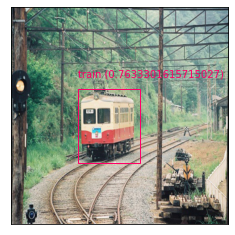

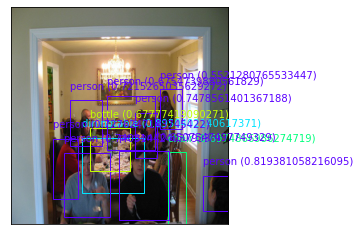

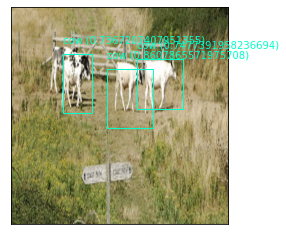

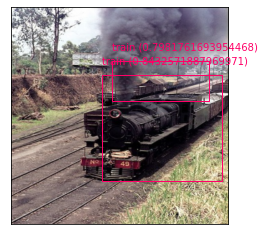

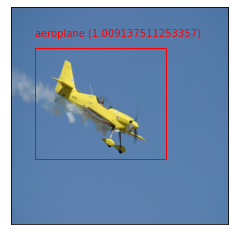

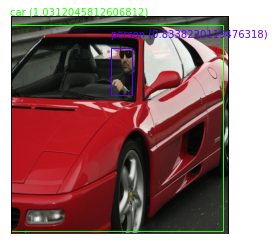

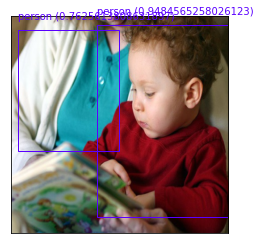

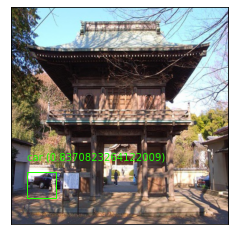

In [12]:
LOAD_MODEL = True
test_boxes('data/train.csv')

## &#8594; Now test set

=> Loading checkpoint


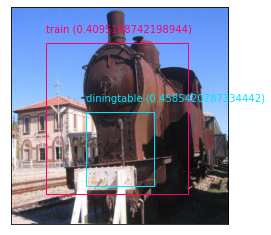

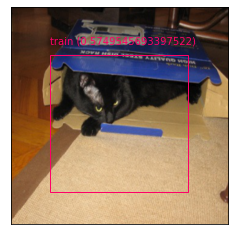

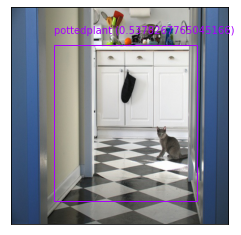

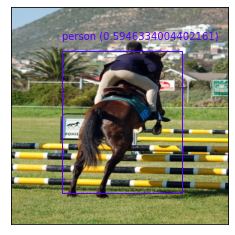

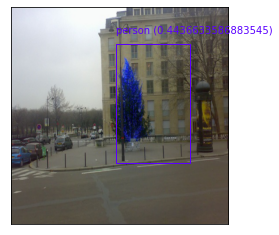

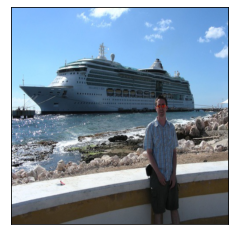

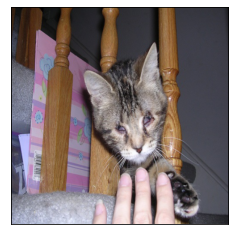

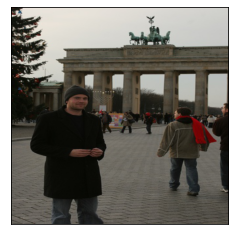

In [13]:
LOAD_MODEL = True
test_boxes('data/test.csv')

# Bonuses:
As you can notice, the current training is not truly successful: the model is in an overfitting regime. This is due to the small size of the training set (which is currently restricted to at most 1K examples). To mitigate overfitting you may consider the following improvement.
* download the entire PascalVOC dataset
* replace the darknet backbone with a pretrained network (e.g. resnet50) and adapt it to output the right tensor shape
* introduce data augmentation (take care to use correctly the `TransformWithBoxes` class, especially if you plan to use geometric transforms)
* modify the components of the loss (eg, Cross Entropy for the class part, and GIOU for the regression part).